In [80]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
import scipy as sc
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params
from GRF_perturbations.Modules.GRF_generation import nonsingular_Power_spectrum,get_k_grid

#Fontsize
FS=18

# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


# Unperturbed image

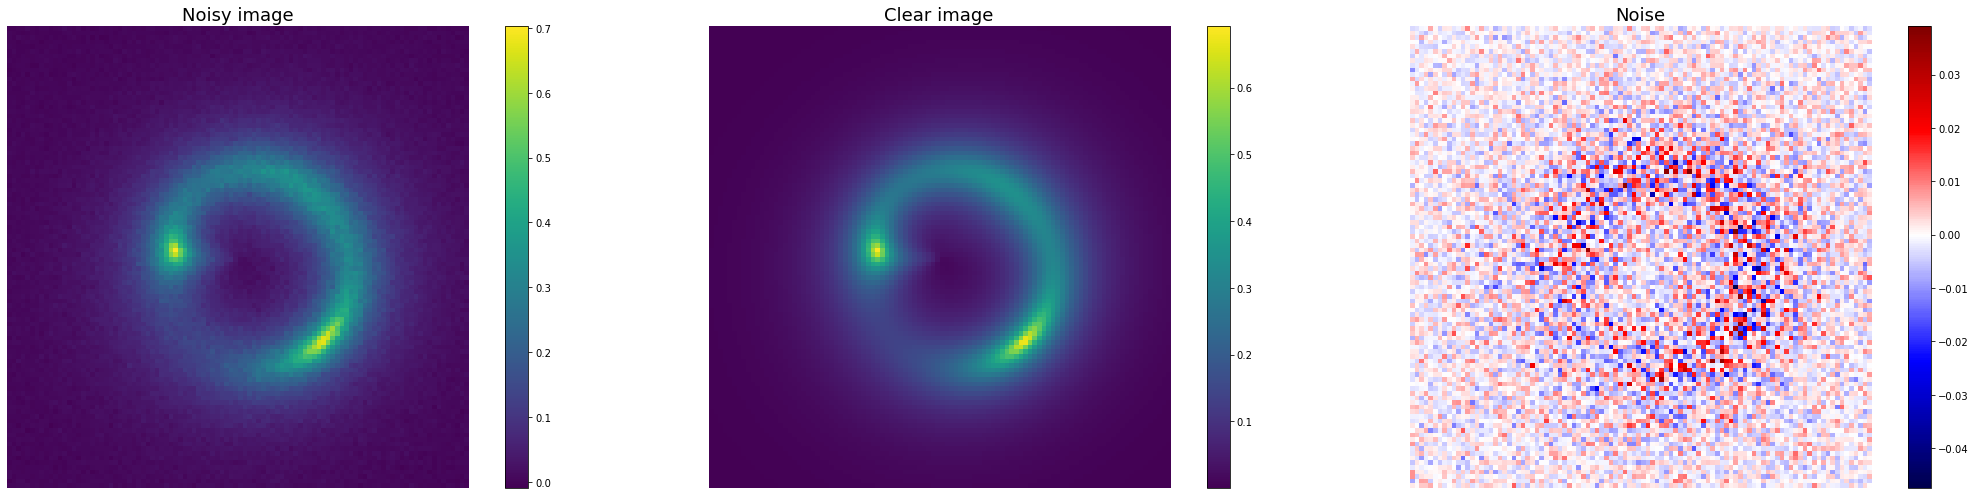

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

log(Variance)=-8.632
log(Spectral energy)=-8.632


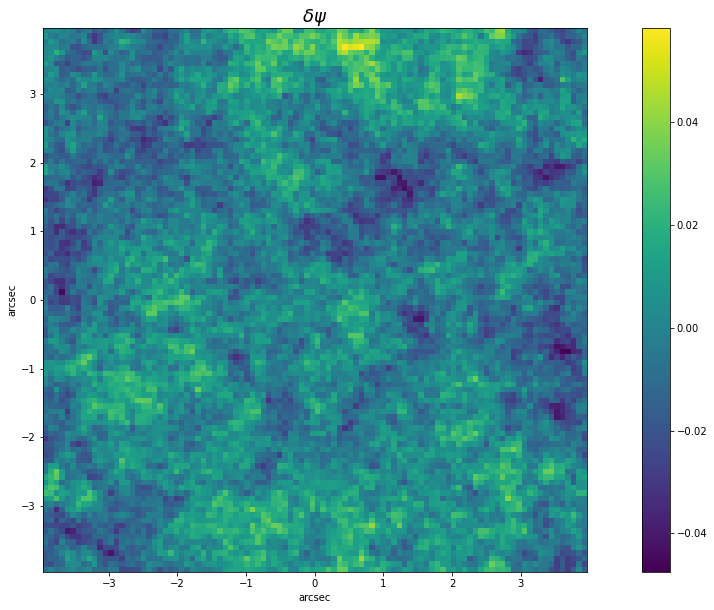

In [14]:
get_GRF=Inference.GRF_getters
k_grid,nonsingular_k_grid=get_k_grid(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
extent = Observation_conditions.pixel_grid.extent


def get_Power_spectrum(GRF_params):
    nonsingular_PS=nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid)
    
    Zero_mean_mask=np.ones_like(nonsingular_k_grid)
    Zero_mean_mask[0,0]=0
    
    return nonsingular_PS*Zero_mean_mask


GRF_params=[-7,2]
field=get_GRF(GRF_params,1)
PS=get_Power_spectrum(GRF_params)

print('log(Variance)={:.3f}'.format(np.log(field.var())))
print('log(Spectral energy)={:.3f}'.format(np.log(PS.sum())))

plt.figure(figsize=(20,10))
plt.imshow(field,extent=extent)

plt.title(r'$\delta \psi$',fontsize=FS)
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.colorbar()
plt.show()

# GRF power slope

The idea is to find such a frequency $\mathit{\widetilde{k}}$ that

$\int PS(k) dk_x dk_y = PS(\widetilde{k}) \int dk_x dk_y $

$\widetilde{\lambda}=\frac{1}{\widetilde{k}}=\left(\frac{\sum_{k_x} \sum_{k_y} k^{-\beta}}{N^2}\right)^{\frac{1}{\beta}}$


The constraint will be $\widetilde{\lambda}<\theta_{E}$,  
where $\theta_{E}$ is the Einstein radius of the unperturbed lens

## Analytic limits

In [21]:
@jax.jit
def get_true_scale(beta):
    Power_Spectum=get_Power_spectrum([0,beta])
    
    total_energy=Power_Spectum.sum()
    
    scale=jnp.power(total_energy/(Observation_conditions.pixel_number**2),1/beta)
    return scale

true_scale_laplacian=jax.grad(jax.grad(get_true_scale))

In [22]:
betas=np.linspace(0.1,6,90)
scales=np.zeros_like(betas)
laplacian_scales=np.zeros_like(betas)

for i,beta in enumerate(betas):
    scales[i]=get_true_scale(beta)
    
    laplacian_scales[i]=true_scale_laplacian(beta)

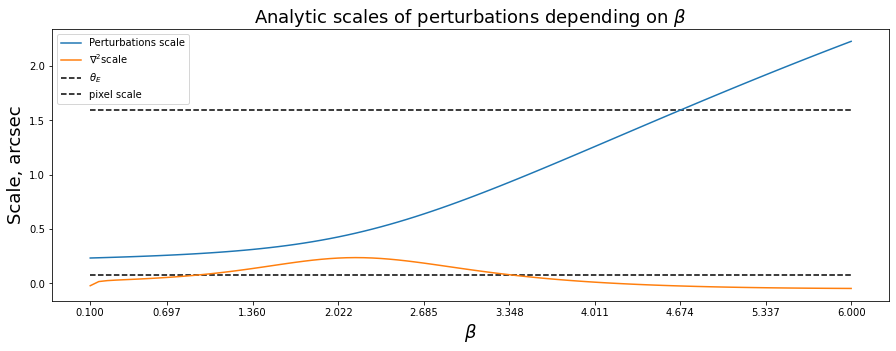

In [23]:
plt.figure(figsize=(15,5))
plt.plot(betas,scales,label='Perturbations scale')
plt.plot(betas,laplacian_scales,label=r'$\nabla^2$'+'scale')

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,90,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Scale, arcsec',fontsize=FS)

plt.title('Analytic scales of perturbations depending on '+r'$\beta$',fontsize=FS)
plt.show()

In [24]:
betas[np.argmin(np.abs(scales-upper_scale))]

4.674157303370786

$\beta$ limits: $\beta>0$ , $\lambda(\beta)<\theta_{E}$

## Data-driven limits

In [30]:
def get_data_scale(beta,GRF_seed_index):
    
    Potential=get_GRF(jnp.array([0.,beta]),GRF_seed_index)
    total_energy=Potential.var()
    
    scale=jnp.power(total_energy/(100**2),1/beta)
    return scale

#data_scale_laplacian=jax.grad(jax.grad(get_data_scale))

In [34]:
data_scales=np.zeros((len(betas),100))
#data_laplacian_scales=np.zeros((len(betas),100))


for GRF_seed_index in tqdm(range(100)):
    for i,beta in enumerate(betas):
        data_scales[i,GRF_seed_index]=get_data_scale(beta,GRF_seed_index)
        #data_laplacian_scales[i,phi]=scale_laplacian(beta)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


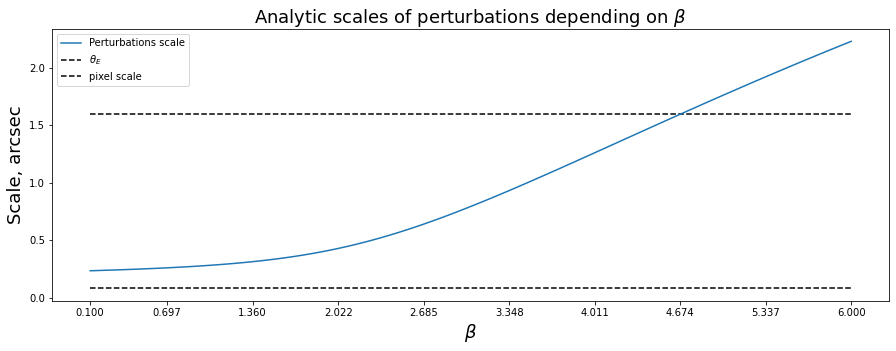

In [35]:
plt.figure(figsize=(15,5))
plt.plot(betas,data_scales.mean(axis=-1),label='Perturbations scale')
plt.fill_between(betas,data_scales.min(axis=-1),data_scales.max(axis=-1),alpha=0.1)

#plt.plot(betas,data_laplacian_scales.mean(axis=-1),label=r'$\nabla^2$'+'scale')
#plt.fill_between(betas[10:],data_laplacian_scales.min(axis=-1)[10:],data_laplacian_scales.max(axis=-1)[10:],alpha=0.1)

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,90,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Scale, arcsec',fontsize=FS)

plt.title('Analytic scales of perturbations depending on '+r'$\beta$',fontsize=FS)
plt.show()

In [38]:
betas[np.argmin(np.abs(data_scales.mean(axis=-1)-upper_scale))]

4.674157303370786

Data driven constraint is identical to the analytic one.
That's actually the proof that our GRF generation meets Parseval's theorem

Let's say that 4.7 will be our limit

# GRF amplitude

The idea is to constriain GRF amplitude in terms of deflection

$A$ : $\delta \alpha (A_{min},0)=pix\_scl$ , $\delta \alpha (A_{max},4.7)=0.2 \times \theta_{E}$

## Data-driven constraints

In [40]:
xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates

betas=np.linspace(0,4.7,30)


total_def_stds=np.zeros((30,100))
total_def_maxs=np.zeros((30,100))

for i,beta in tqdm(enumerate(betas)):
    for GRF_seed_index in range(100):
        alpha_x,alpha_y=Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha(xgrid,ygrid,[{},{},{'pixels':get_GRF([-7,beta],GRF_seed_index)}],k=2)
        total_def=np.sqrt(alpha_x**2+alpha_y**2)
        total_def_stds[i,GRF_seed_index]=total_def.std()
        total_def_maxs[i,GRF_seed_index]=total_def.max()
        


30it [05:06, 10.23s/it]


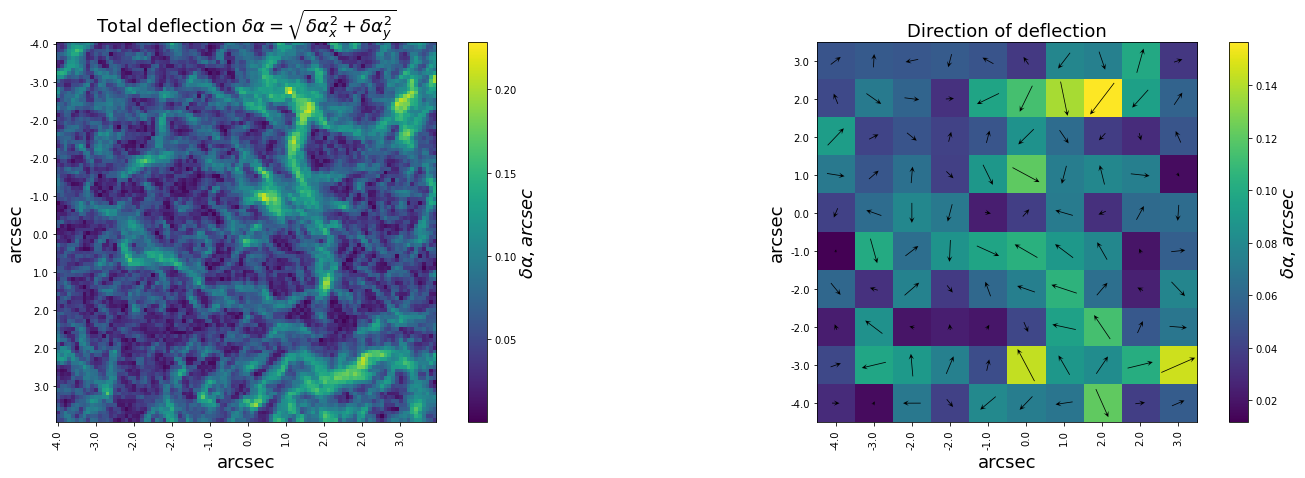

In [154]:
alpha_x,alpha_y=Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha(xgrid,ygrid,[{},{},{'pixels':get_GRF([-7,4],0)}],k=2)
total_def=np.sqrt(alpha_x**2+alpha_y**2)

fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(total_def,cmap='viridis')]
img_arr+=[ax[1].imshow(np.sqrt(I**2+J**2),cmap='viridis')]
ax[1].quiver(I, J,scale=1.5,width=0.002,headwidth=7,headlength=7.5,pivot='middle',color='k')

ax[0].set_yticks(np.arange(0,100,10))
ax[0].set_xticks(np.arange(0,100,10))

ax[1].set_yticks(np.arange(0,10))
ax[1].set_xticks(np.arange(0,10))

ax[1].invert_yaxis()

ax[0].set_title('Total deflection '+r'$\delta \alpha=\sqrt{\delta \alpha_x^2+\delta \alpha_y^2}$',fontsize=FS)
ax[1].set_title('Direction of deflection',fontsize=FS)

for i in range(2):
    ax[i].set_yticklabels(Y[::10,0].round(0))
    ax[i].set_xticklabels(X[0,::10].round(0),rotation=90)
    
    ax[i].set_ylabel('arcsec',fontsize=FS)
    ax[i].set_xlabel('arcsec',fontsize=FS)
    
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(r'$\delta \alpha, arcsec$',rotation=90,fontsize=FS,labelpad=2)


In [152]:
#np.savez('data/deflection_stats',total_def_stds=total_def_stds,total_def_maxs=total_def_maxs)
arr=np.load('data/deflection_stats.npz')
total_def_stds=arr['total_def_stds']
total_def_maxs=arr['total_def_maxs']

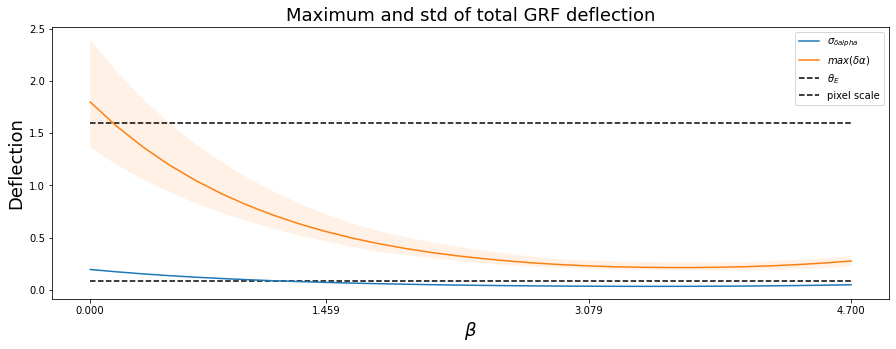

In [153]:
plt.figure(figsize=(15,5))
plt.plot(betas,total_def_stds.mean(axis=-1),label=r'$\sigma_{\delta alpha}$')
plt.fill_between(betas,total_def_stds.min(axis=-1),total_def_stds.max(axis=-1),alpha=0.1)

plt.plot(betas,total_def_maxs.mean(axis=-1),label=r'$max(\delta \alpha)$')
plt.fill_between(betas,total_def_maxs.min(axis=-1),total_def_maxs.max(axis=-1),alpha=0.1)

upper_scale=Observation_conditions.kwargs_lens_mass[0]['theta_E']
lower_scale=Observation_conditions.pixel_scale

plt.hlines(upper_scale,betas[0],betas[-1],label=r'$\theta_{E}$',color='k',linestyle='--')
plt.hlines(lower_scale,betas[0],betas[-1],label='pixel scale',color='k',linestyle='--')


plt.legend()
xticks=betas[np.arange(9,30,10)]
plt.xticks(np.append([betas[0]],xticks))
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Deflection',fontsize=FS)

plt.title('Maximum and std of total GRF deflection',fontsize=FS)

plt.show()

In [47]:
# deflection = 0.2 * theta_E
top_adjustment=0.2*Observation_conditions.kwargs_data['kwargs_lens'][0]['theta_E']/total_def_maxs.mean(axis=-1)[-1]
logA_top=np.log10(1e-7*top_adjustment**2)

In [48]:
# deflection = pixel_scale
bot_adjustment=pixel_scale/total_def_maxs.mean(axis=-1)[0]
logA_bot=np.log10(1e-7*bot_adjustment**2)

$\delta \alpha (A_{max},4.7)=0.2 \times \theta_{E}$

In [51]:
print('log(A_max)={:.2f}'.format(logA_top))

log(A_max)=-6.87


$\delta \alpha (A_{min},0)=pix\_scl$

In [52]:
print('log(A_min)={:.2f}'.format(logA_bot))

log(A_min)=-9.70


# Region borders

In [53]:
logA_borders=[-9.7,-6.87]
Beta_borders=[0,4.7]